In [2]:
from dataclasses import dataclass
from typing import Optional, Mapping, Sequence, Tuple
from collections import Counter
import numpy as np
from numpy.random import binomial
import itertools
from operator import itemgetter
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func

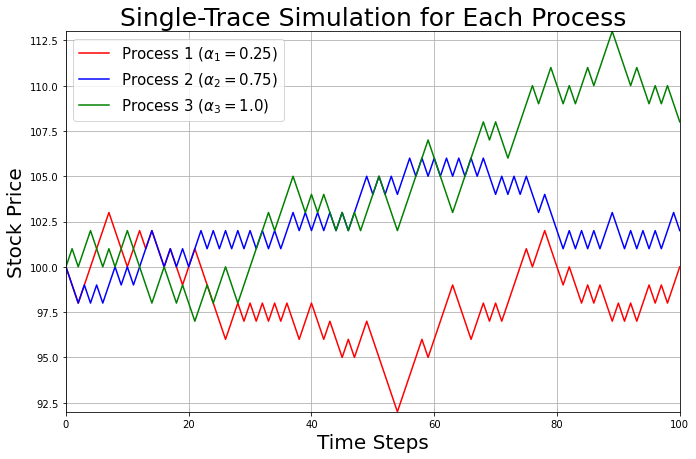

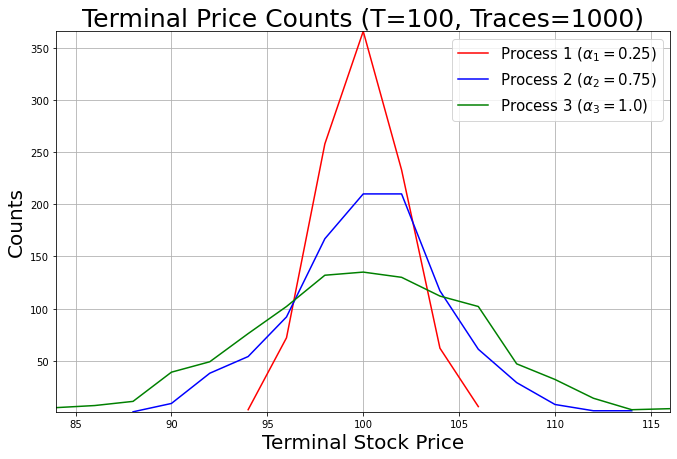

In [3]:
@dataclass
class Process1:
    @dataclass
    class State:
        price: int


    level_param: int  # level to which price mean-reverts
    alpha1: float = 0.25  # strength of mean-reversion (non-negative value)

    def up_prob(self, state: State) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)


handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}


@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]

    alpha2: float = 0.75  # strength of reverse-pull (value in [0,1])

    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )


@dataclass
class Process3:
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int

    alpha3: float = 1.0  # strength of reverse-pull (non-negative value)

    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        return get_unit_sigmoid_func(self.alpha3)(
            state.num_down_moves / total
        ) if total else 0.5

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(
            num_up_moves=state.num_up_moves + up_move,
            num_down_moves=state.num_down_moves + 1 - up_move
        )


def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)


def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process3_price_traces(
    start_price: int,
    alpha3: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves
                    for s in itertools.islice(simulation(process, start_state),
                                              time_steps + 1)), float)
        for _ in range(num_traces)])


def plot_single_trace_all_processes(
    process1_trace: np.ndarray,
    process2_trace: np.ndarray,
    process3_trace: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    traces_len = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )


def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]


def plot_distribution_at_time_all_processes(
    process1_traces: np.ndarray,
    process2_traces: np.ndarray,
    process3_traces: np.ndarray
) -> None:

    from rl.gen_utils.plot_funcs import plot_list_of_curves

    num_traces = len(process1_traces)
    time_steps = len(process1_traces[0]) - 1

    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r", "b", "g"],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )


if __name__ == '__main__':
    start_price: int = 100
    level_param: int = 100
    alpha1: float = 0.25
    alpha2: float = 0.75
    alpha3: float = 1.0
    time_steps: int = 100
    num_traces: int = 1000

    process1_traces: np.ndarray = process1_price_traces(
        start_price=start_price,
        level_param=level_param,
        alpha1=alpha1,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process2_traces: np.ndarray = process2_price_traces(
        start_price=start_price,
        alpha2=alpha2,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process3_traces: np.ndarray = process3_price_traces(
        start_price=start_price,
        alpha3=alpha3,
        time_steps=time_steps,
        num_traces=num_traces
    )

    trace1 = process1_traces[0]
    trace2 = process2_traces[0]
    trace3 = process3_traces[0]

    plot_single_trace_all_processes(trace1, trace2, trace3)

    plot_distribution_at_time_all_processes(
        process1_traces,
        process2_traces,
        process3_traces
    )


In [6]:
process1_traces

array([[100.,  99.,  98., ...,  98.,  99., 100.],
       [100., 101., 102., ..., 100., 101., 102.],
       [100.,  99., 100., ...,  96.,  97.,  98.],
       ...,
       [100., 101., 102., ..., 100.,  99., 100.],
       [100., 101., 102., ...,  98.,  99.,  98.],
       [100.,  99., 100., ..., 102., 103., 104.]])

In [22]:
a=Process2()
start_s=Process2.State(1,False)